In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Features relevant to predicting price of a listing

In [2]:
columns = ["Country", "City", "State", "Neighbourhood Cleansed", 
"Host Since", "Host Response Time", "Host Response Rate", "Calculated host listings count",
"Property Type", "Room Type", "Accommodates", "Bedrooms", "Beds", "Bed Type",  "Square Feet", "Cancellation Policy",
"Minimum Nights", "Maximum Nights", "Has Availability", "Availability 30", "Availability 60", "Availability 90", "Availability 365",
"Number of Reviews", "Reviews per Month", "First Review", "Last Review", "Review Scores Rating", "Review Scores Accuracy", "Review Scores Cleanliness","Review Scores Checkin", "Review Scores Communication", "Review Scores Location","Review Scores Value",
"Features",
"Amenities",
"Price"]

# "Neighbourhood Group Cleansed",
# "Square Feet": 97.56% of entries have NULL values => cannot be used
# "Calendar Updated"
# "Weekly Price", "Monthly Price", "Security Deposit", "Cleaning Fee", "Guests Included", "Extra People",

features_new_host = ["Country", "City", "Neighbourhood Cleansed",
                   "Property Type", "Room Type", "Accommodates","Bedrooms", "Beds", "Bed Type", "Cancellation Policy",
                   "Minimum Nights",
                   "Price"]

features_existing_host = ["Country", "City", "Neighbourhood Cleansed",
                          "Property Type", "Room Type", "Accommodates", "Bedrooms", "Beds", "Bed Type", "Cancellation Policy",
                          "Minimum Nights", "Availability 30", "Availability 60", "Availability 90", "Availability 365",
                          "Number of Reviews", "Reviews per Month", "Review Scores Rating", "Review Scores Accuracy", "Review Scores Cleanliness","Review Scores Checkin", "Review Scores Communication", "Review Scores Location","Review Scores Value",
                          "Host Since", "Host Response Time", "Host Response Rate", "Calculated host listings count",
                          "Price"]

############################################
########## Feature pre-processing ##########
#### Numerical (Input text fields)
# "Minimum Nights", "Availability 30", "Availability 60", "Availability 90", "Availability 365"
# "Number of Reviews", 
# Review Scores Rating(20-100)
# "Host Since" (num_days = current_date - host_since_date), Host Response Rate(0-100), "Calculated host listings count"
# Price (Convert from local currency to USD)

#### Numerical (Dropdown numerical values)
# Accommodates(1-16), "Bedrooms"(0-10), "Beds"(0-16)
# "Review Scores Accuracy(2-10)", "Review Scores Cleanliness(2-10)","Review Scores Checkin(2-10)", "Review Scores Communication(2-10)", "Review Scores Location(2-10)","Review Scores Value(2-10)"

#### Label encoding (0, 1, 2 .... n_categories-1) (Category dropdowns -> on user select must be assigned numerical value)
# "Country", "City", "Neighbourhood Cleansed"
# "Property Type", "Room Type", "Bed Type", "Cancellation Policy"
# "Host Response Time"
############################################


# TODO
# Host since -> convert to days ----------------------------------- Done
# Features -> Extract features  ----------------------------------- Done
# Amenities -> Extract features ----------------------------------- Done
# Price -> Convert to local currency
# Verify missing features (Listing type etc...) ------------------- Done
# Decide what plots to be shown in exploratory analysis section ---
# Flask vs Flast + React ------------------------------------------ Done (Flask)

In [3]:
df = pd.read_csv("../../data/airbnb-data-science/airbnb-listings.csv", usecols=columns, sep=';')
df = df[columns]
df.head(2)

/Users/nesara/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (66) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Country,City,State,Neighbourhood Cleansed,Host Since,Host Response Time,Host Response Rate,Calculated host listings count,Property Type,Room Type,...,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Features,Amenities,Price
0,Netherlands,Amsterdam,Noord-Holland,Watergraafsmeer,2017-03-28,NaN,NaN,1.0,Apartment,Entire home/apt,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Host Has Profile Pic,"TV,Kitchen,Heating,Washer,Smoke detector,Lapto...",80.0
1,Netherlands,Amsterdam,Noord-Holland,Watergraafsmeer,2014-10-21,within a day,100.0,1.0,House,Entire home/apt,...,94.0,9.0,9.0,10.0,9.0,10.0,9.0,"Host Has Profile Pic,Host Identity Verified,Is...","TV,Wireless Internet,Kitchen,Heating,Family/ki...",195.0


In [4]:
dfo = df.copy()
len(dfo)

485419

In [205]:
485419/192 * 8 

20225.791666666668

## Data cleaning

### Existing hosts

In [163]:
#df = dfo.copy()
df = dfo[features_existing_host].copy()

enable_separate_features = 0
enable_separate_amenities = 0

########################################################
############ Location Features #############
###### Countries ######## 
# Remove countries with very few entries
exclude_low_count_countries_list = ["0", "Cuba", "Mexico", "Uruguay", "Vanuatu", "Vatican City"]
df = df[~df["Country"].isin(exclude_low_count_countries_list)]
# Remove null (3 entries)
df = df[~pd.isnull(df["Country"])]

###### City ######## 
# Remove cities with less than 10 listings 
# (Total over 4000 cities, 800 odd unique cities with more than 10 listings)
df = df.groupby("City").filter(lambda x: len(x)>10)
# Remove null (451 entries)
df = df[~pd.isnull(df["City"])]


###### Neighbourhood Cleansed ######
# Remove integer Neighbourhood names
df = df[df.apply(lambda x: not x["Neighbourhood Cleansed"].startswith("7"), axis=1)].copy()
# Remove Neighbourhood with less than 10 listings 
# (Total over 2200 cities, 1500 odd unique cities with more than 10 listings)
df = df.groupby("Neighbourhood Cleansed").filter(lambda x: len(x)>10)

# Remove null (1 entry)
df = df[~pd.isnull(df["Neighbourhood Cleansed"])]
#######################################################


####################################################################
############ Basic (Beds, Area, Cancellation) Features #############

###### Property Type #####
# Remove null (11 entries)
df = df[~pd.isnull(df["Property Type"])]
# Remove types with less than 10 entries
df = df.groupby("Property Type").filter(lambda x: len(x)>=10)

###### Room Type #####
# Remove null (1 entries)
df = df[~pd.isnull(df["Room Type"])]

###### Accommodates #####
# Remove null (63 entries)
df = df[~pd.isnull(df["Accommodates"])]
# Accommodate maximum 16 people
df = df[df["Accommodates"] <= 16]

###### Bedrooms #########
# Remove null (597 entries)
df = df[~pd.isnull(df["Bedrooms"])]
# Remove more than 10 bedrooms
df = df[df["Bedrooms"] <= 10]

###### Beds #########
# Remove null (903 entries)
df = df[~pd.isnull(df["Beds"])]
# Remove more than 16 beds (2 entries)
df = df[df["Beds"] <= 16]

###### Bed Type #########
# Remove null (1 entry)
df = df[~pd.isnull(df["Bed Type"])]

###### Cancellation Policy #########
# Remove cancellation policy with low entries (3)
exclude_cancellation_policy_list = ["long_term", "no_refunds"]
df = df[~df["Cancellation Policy"].isin(exclude_cancellation_policy_list)]
# Remove null (2 entries)
df = df[~pd.isnull(df["Cancellation Policy"])]
####################################################################


##########################################################
######### Availability #########

###### Minimum Nights #########
# Remove "Minimum Nights" above 30 except for multiples of 30 (corresponding to months)
df = df[(df["Minimum Nights"]<=31) | (df["Minimum Nights"].isin([60, 90, 120, 180]))]
# Remove null (2 entries)
df = df[~pd.isnull(df["Minimum Nights"])]

###### Availability 30 #########
# Remove null (2 entries)
df = df[~pd.isnull(df["Availability 30"])]

###### Availability 60 #########
# Remove null (2 entries)
df = df[~pd.isnull(df["Availability 60"])]

###### Availability 90 #########
# Remove null (2 entries)
df = df[~pd.isnull(df["Availability 90"])]

###### Availability 365 #########
# Remove null (2 entries)
df = df[~pd.isnull(df["Availability 365"])]
##########################################################


##########################################################
######### Reviews #########

###### Number of Reviews #########
# Remove entries with 0 reviews (Use Model for new host in this case)
df = df[df["Number of Reviews"] > 0]
# Remove null (2 entries)
df = df[~pd.isnull(df["Number of Reviews"])]

###### Reviews per Month #########
#df.at[(df["Number of Reviews"]==0) & (df[pd.isnull("Reviews per Month")]), "Reviews per Month"] = 0
# Remove null (235 entries)
df = df[~pd.isnull(df["Reviews per Month"])]

##### Reviews Scores #############
df = df[~pd.isnull(df["Review Scores Rating"])]
df = df[~pd.isnull(df["Review Scores Accuracy"])]
df = df[~pd.isnull(df["Review Scores Cleanliness"])]
df = df[~pd.isnull(df["Review Scores Checkin"])]
df = df[~pd.isnull(df["Review Scores Communication"])]
df = df[~pd.isnull(df["Review Scores Location"])]
df = df[~pd.isnull(df["Review Scores Value"])]
##########################################################



##########################################################
######### Host Features #########

###### Host Since #########
# Remove null (504 entries)
df = df[~pd.isnull(df["Host Since"])]

# Convert date to number of days till today
today_date = pd.to_datetime(pd.to_datetime("today").date())
df["Host Since"] = pd.to_datetime(df["Host Since"])
df["Host Since Days"] = (today_date - df["Host Since"])
df['Host Since Days'] = df[['Host Since Days']].apply(pd.to_numeric)
df['Host Since Days'] = df['Host Since Days'] / (24*60*60*1e9) #np.timedelta64(1, 'D')
df["Host Since Days"] = df["Host Since Days"].astype(int)

###### Host Response Time #####
# Assign "a few days or more" to entries with NULL values for "Host Response Time"
df.at[pd.isnull(df["Host Response Time"]), "Host Response Time"] = "a few days or more"

###### Host Response Rate #####
# Assign mean(93.4) to entries with NULL values for "Host Response Rate"
df.at[pd.isnull(df["Host Response Rate"]), "Host Response Rate"] = dfo["Host Response Rate"].mean()

###### Calculated host listings count #####
# Assign 1 to entries with NULL values for "Calculated host listings count"
df.at[pd.isnull(df["Calculated host listings count"]), "Calculated host listings count"] = 1
##########################################################



##########################################################
######### Extract Features #########
"""
features_list = []
for i in range(len(df["Features"].unique())):
    if not pd.isnull(df["Features"].unique()[i]):
        features = df["Features"].unique()[i].split(",")
        for ft in features:
            if ft not in features_list:
                features_list.append(ft)
"""

features_list = ['Host Has Profile Pic',
                 'Host Identity Verified',
                 'Is Location Exact',
                 'Instant Bookable',
                 'Host Is Superhost',
                 'Require Guest Phone Verification',
                 'Require Guest Profile Picture',
                 'Requires License']

# Assign 0 to all the above features
for i in range(len(features_list)):
    ft = features_list[i]
    df[ft] = 0


if enable_separate_features == 1:
    # Assign 1 if that feature is present
    for i in range(len(df)):
        idx = df.index[i]
        features = df.loc[idx]["Features"]
        if not pd.isnull(features):
            features = features.split(",")
            for ft in features:
                df.at[idx, ft] = 1
##########################################################



##########################################################
######### Extract Amenities #########
"""
amenities_list = []
for i in range(len(df["Amenities"].unique())):
    if not pd.isnull(df["Amenities"].unique()[i]):
        amenities = df["Amenities"].unique()[i].split(",")
        for ft in amenities:
            if ft not in amenities_list:
                amenities_list.append(ft)
amenities_list
"""
amenities_list = ['TV',
                 'Wireless Internet',
                 'Kitchen',
                 'Heating',
                 'Family/kid friendly',
                 'Washer',
                 'Smoke detector',
                 'Fire extinguisher',
                 'Essentials',
                 'Cable TV',
                 'Internet',
                 'Dryer',
                 'First aid kit',
                 'Safety card',
                 'Shampoo',
                 'Hangers',
                 'Laptop friendly workspace',
                 'Air conditioning',
                 'Breakfast',
                 'Free parking on premises',
                 'Elevator in building',
                 'Buzzer/wireless intercom',
                 'Hair dryer',
                 'Private living room',
                 'Iron',
                 'Wheelchair accessible',
                 'Hot tub',
                 'Carbon monoxide detector',
                 '24-hour check-in',
                 'Pets live on this property',
                 'Dog(s)',
                 'Gym',
                 'Lock on bedroom door',
                 'Private entrance',
                 'Indoor fireplace',
                 'Smoking allowed',
                 'Pets allowed',
                 'Cat(s)',
                 'Self Check-In',
                 'Doorman Entry',
                 'Suitable for events',
                 'Pool',
                 'Lockbox',
                 'Bathtub',
                 'Room-darkening shades',
                 'Game console',
                 'Doorman',
                 'High chair',
                 'Pack ’n Play/travel crib',
                 'Keypad',
                 'Other pet(s)',
                 'Smartlock']

# Assign 0 to all the above amenities
for i in range(len(amenities_list)):
    ft = amenities_list[i]
    df[ft] = 0

    
if enable_separate_amenities == 1:
    # Assign 1 if those amenities are present
    for i in range(len(df)):
        idx = df.index[i]
        amenities = df.loc[idx]["Amenities"]
        if not pd.isnull(amenities):
            amenities = amenities.split(",")
            for ft in amenities:
                df.at[idx, ft] = 1              
##########################################################



##########################################################
######### Price (Output variable) #########


### TODO: Convert to local currency

# Remove null (7954 entries)
df = df[~pd.isnull(df["Price"])]
# Remove 0 (4 entries)
df = df[df["Price"] > 0]

##########################################################

In [164]:
len(df)

337588

In [165]:
df.head(2)

,Country,City,Neighbourhood Cleansed,Property Type,Room Type,Accommodates,Bedrooms,Beds,Bed Type,Cancellation Policy,...,Lockbox,Bathtub,Room-darkening shades,Game console,Doorman,High chair,Pack ’n Play/travel crib,Keypad,Other pet(s),Smartlock
1,Netherlands,Amsterdam,Watergraafsmeer,House,Entire home/apt,4.0,4.0,5.0,Real Bed,strict,...,0,0,0,0,0,0,0,0,0,0
2,Netherlands,Amsterdam,Watergraafsmeer,Apartment,Entire home/apt,4.0,2.0,2.0,Real Bed,moderate,...,0,0,0,0,0,0,0,0,0,0


#### Save list of countries, cities etc to set dropdown options 

In [28]:
"""
dft = df[["Country"]].drop_duplicates().copy()
dft.reset_index(inplace=True)
del dft["index"]
dft.reset_index(inplace=True)
dft.rename(columns={"index":"id"}, inplace=True)
dft.to_csv("../data/list_countries.csv", index=False)
dft

dft = df[["City"]].drop_duplicates().copy()
dft.reset_index(inplace=True)
del dft["index"]
dft.reset_index(inplace=True)
dft.rename(columns={"index":"id"}, inplace=True)
dft.to_csv("../data/list_cities.csv", index=False)
dft

dft = df[["Neighbourhood Cleansed"]].drop_duplicates().copy()
dft.reset_index(inplace=True)
del dft["index"]
dft.reset_index(inplace=True)
dft.rename(columns={"index":"id"}, inplace=True)
dft.to_csv("../data/list_neighbourhood.csv", index=False)
#dft

dft = df[["Property Type"]].drop_duplicates().copy()
dft.reset_index(inplace=True)
del dft["index"]
dft.reset_index(inplace=True)
dft.rename(columns={"index":"id"}, inplace=True)
dft.to_csv("../data/list_propertytype.csv", index=False)
dft

dft = df[["Room Type"]].drop_duplicates().copy()
dft.reset_index(inplace=True)
del dft["index"]
dft.reset_index(inplace=True)
dft.rename(columns={"index":"id"}, inplace=True)
dft.to_csv("../data/list_roomtype.csv", index=False)
dft

dft = df[["Cancellation Policy"]].drop_duplicates().copy()
dft.reset_index(inplace=True)
del dft["index"]
dft.reset_index(inplace=True)
dft.rename(columns={"index":"id"}, inplace=True)
dft.to_csv("../data/list_cancellationpolicy.csv", index=False)

dft = df[["Bed Type"]].drop_duplicates().copy()
dft.reset_index(inplace=True)
del dft["index"]
dft.reset_index(inplace=True)
dft.rename(columns={"index":"id"}, inplace=True)
dft.to_csv("../data/list_bedtype.csv", index=False)

dft = df[["Host Response Time"]].drop_duplicates().copy()
dft.reset_index(inplace=True)
del dft["index"]
dft.reset_index(inplace=True)
dft.rename(columns={"index":"id"}, inplace=True)
dft.to_csv("../data/list_hostresponsetime.csv", index=False)
"""

#### Combined pipeline for both numerical and categorical features

In [166]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer


##########################################################
############ Pipeline for numerical features #############
# Select numerical columns only
numerical_attribs = [   'Accommodates', 'Bedrooms', 'Beds', 'Minimum Nights',
             'Availability 30', 'Availability 60', 'Availability 90',
             'Availability 365', 'Number of Reviews', 'Reviews per Month',
             'Review Scores Rating', 'Review Scores Accuracy', 'Review Scores Cleanliness',
             'Review Scores Checkin', 'Review Scores Communication', 'Review Scores Location',
             'Review Scores Value', 'Host Response Rate']
#df_num = df.select_dtypes(include=[np.number])
numerical_pipeline = Pipeline([
        #('imputer', SimpleImputer(strategy="median")),
        #('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        ('std_scaler', StandardScaler()),
    ])
#df_num_tr = numerical_pipeline.fit_transform(df_num)
#df_num_tr
##########################################################


##########################################################
########## Pipeline for categorical features #############
categorical_attribs = ["Country", "City", "Neighbourhood Cleansed",
                    "Property Type", "Room Type", "Bed Type", "Cancellation Policy",
                    "Host Response Time"]
#df_cat = df[categorical_columns]

# Encode categorical features as integers
# ordinal_encoder = OrdinalEncoder()
# df_cat_encoded = ordinal_encoder.fit_transform(df_cat)
categorical_pipeline = Pipeline([
                            ('ordinal_encoder', OrdinalEncoder()),
                            ])
##########################################################


##########################################################
########## Combined Pipeline for all features ############
preprocessing_pipeline = ColumnTransformer([
        ("categorical", categorical_pipeline, categorical_attribs),
        ("numerical", numerical_pipeline, numerical_attribs),
    ])

label = ["Price"]

df_attribs = df[categorical_attribs + numerical_attribs + label].copy()
df_prepared = preprocessing_pipeline.fit_transform(df[categorical_attribs + numerical_attribs])

# Save preprocessing pipeline
save_model(model=preprocessing_pipeline, save_path="../webapp/static/model/preprocessing_pipeline.pkl")
##########################################################

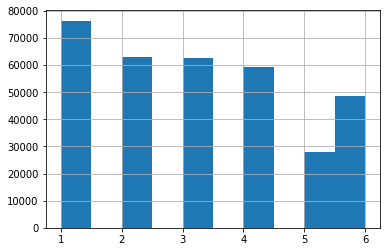

In [168]:
### Price Categories (in USD)
# 1:10-50 2:50-75 3:75-100 4:100-150 5:150-200 6:>200
df_attribs["Price Label"] = pd.cut(df["Price"],
                           bins=[0., 50., 75., 100.0, 150., 200., np.inf],
                           labels=[1, 2, 3, 4, 5, 6])

# Distribution of class labels in overall dataset
df_attribs["Price Label"].hist()

### Split Dataset into train and test sets

In [169]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

df_attribs.reset_index(inplace=True)
del df_attribs["index"]

"""
dfx = df.copy()
del dfx["Price"]
dfy = df["Price"].copy()
x_train, x_test, y_train, y_test = train_test_split(dfx,dfy, test_size=0.1, random_state=42)
"""

# Stratified split
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, test_index in split.split(df_attribs, df_attribs["Price Label"]):
    strat_train_set = df_attribs.loc[train_index]
    strat_test_set = df_attribs.loc[test_index]

### Univariate, scatter matrix analysis

In [170]:
df_strat_train = strat_train_set.copy()

#from pandas.plotting import scatter_matrix
#attributes = ["Review Scores Rating", "Price"]
#scatter_matrix(df[attributes], figsize=(12, 8))

### Prepare the data for Machine Learning algorithms

In [203]:
# drop labels for training set
df = strat_train_set.drop(["Price", "Price Label"], axis=1) 
df_labels = strat_train_set["Price"].copy()

#### Handling missing values

In [ ]:
"""
# Check if there are any rows with NULL values
sample_incomplete_rows = df[df.isnull().any(axis=1)] #.head()
len(sample_incomplete_rows)

# Option 1: Remove rows with NULL values for any subset of columns
# sample_incomplete_rows.dropna(subset=["Bedrooms"])

# Option 2: Remove columns with NULL values
# sample_incomplete_rows.drop("Bedrooms", axis=1)

# Option 3: Fill NULL values with median values of corresponding columns

### Method 1: Manual
# median = df["Bedrooms"].median()
# sample_incomplete_rows["Bedrooms"].fillna(median, inplace=True)

### Method 2: sklearn in-built (Works when all numerical columns NULL is to be replaced with median)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
# Select numerical columns only
df_num = df_xtrain.select_dtypes(include=[np.number])
imputer.fit(df_num)
X = imputer.transform(df_num)
Xtrain = pd.DataFrame(X, columns=df_num.columns,
                          index=df_num.index)
"""

#### Adding extra features 

In [ ]:
"""
from sklearn.preprocessing import FunctionTransformer

def add_extra_features(X, add_bedrooms_per_room=True):
    rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
    population_per_household = X[:, population_ix] / X[:, household_ix]
    if add_bedrooms_per_room:
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_household, population_per_household,
                     bedrooms_per_room]
    else:
        return np.c_[X, rooms_per_household, population_per_household]

attr_adder = FunctionTransformer(add_extra_features, validate=False,
                                 kw_args={"add_bedrooms_per_room": False})
df_extra_attribs = attr_adder.fit_transform(df.values)
"""

## Exploratory analysis, feature selection

In [204]:
df

,Country,City,Neighbourhood Cleansed,Property Type,Room Type,Bed Type,Cancellation Policy,Host Response Time,Accommodates,Bedrooms,...,Number of Reviews,Reviews per Month,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Host Response Rate
123603,Australia,North Sydney,North Sydney,Apartment,Entire home/apt,Real Bed,moderate,a few days or more,4.0,2.0,...,4.0,0.22,95.0,10.0,9.0,9.0,10.0,10.0,10.0,0.000000
327368,Spain,Madrid,Casa de Campo,Apartment,Entire home/apt,Real Bed,moderate,within an hour,4.0,2.0,...,6.0,1.86,97.0,10.0,10.0,10.0,10.0,10.0,10.0,90.000000
334497,France,Paris,Popincourt,Apartment,Entire home/apt,Real Bed,moderate,within a day,2.0,0.0,...,5.0,4.05,96.0,10.0,10.0,10.0,10.0,10.0,10.0,100.000000
42494,Spain,Madrid,Universidad,Apartment,Entire home/apt,Real Bed,strict,within an hour,3.0,0.0,...,20.0,3.47,90.0,10.0,9.0,10.0,10.0,10.0,9.0,100.000000
122021,Italy,Rome,I Centro Storico,Apartment,Entire home/apt,Real Bed,moderate_new,within an hour,6.0,2.0,...,162.0,2.61,93.0,9.0,9.0,10.0,10.0,10.0,9.0,100.000000
59660,Denmark,København,Vesterbro-Kongens Enghave,Apartment,Entire home/apt,Real Bed,strict,within an hour,4.0,2.0,...,5.0,0.30,93.0,10.0,9.0,10.0,10.0,9.0,9.0,100.000000
251551,United States,Washington,"Kalorama Heights, Adams Morgan, Lanier Heights",Apartment,Entire home/apt,Real Bed,super_strict_30,within a day,3.0,1.0,...,8.0,0.12,88.0,10.0,9.0,10.0,10.0,10.0,9.0,68.000000
130785,United States,Los Angeles,North Hollywood,Apartment,Entire home/apt,Real Bed,moderate,within a few hours,3.0,1.0,...,7.0,0.70,91.0,9.0,9.0,10.0,10.0,10.0,9.0,75.000000
88290,France,Paris,Opéra,Apartment,Entire home/apt,Real Bed,flexible,a few days or more,2.0,1.0,...,53.0,1.46,95.0,10.0,9.0,10.0,10.0,9.0,10.0,93.399318
318684,France,Paris,Panthéon,Apartment,Private room,Real Bed,strict,within an hour,2.0,1.0,...,2.0,2.00,90.0,10.0,10.0,9.0,9.0,10.0,10.0,100.000000


## Model training and selection

In [ ]:
### Model training and selection pipeline

# Model selection
## For each ML Model
#### 1. Use Grid Search or Randomized search to find best parameters (get_hyperparameter_search_results)
#### 2. Plots to show how CV mean score varies by varying different parameters
####        For each parameter being searched, fix all but one parameter, plot rmse vs one varying parameter
#### 3. Plots to show feature importance
#### 4. Save best estimator

# Model comparison
## For each ML Model
#### 1. Get test RMSE results, mean, SE, 95%_ci etc (get_test_results)
## Visualise models (?)
####    https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
####    Actual labels vs predicted values (show best fit line with confidence_interval)  -- use different colors for different ML models
####    Residuals vs predicted values
####    Different regression metrics (R2, MSE, MAE, Variance explained etc)
## Visualise box plots of test results from all models
####    https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/
## Choose the best model and save for serving using Flask

In [183]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
#from sklearn.externals import joblib
import joblib

def save_model(save_path, model):
    joblib.dump(model, save_path) # DIFF    

def load_model(load_path):
    my_model_loaded = joblib.load(load_path)
    return my_model_loaded
    
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    

# Function to get grid search results
def get_hyperparameter_search_results(model, df_train, df_labels, search_type,
                                      param_grid, param_distributions, n_iter, cv):
    """
    Get hyperparameter search results
    @params
        model:        ML Model
        df_train      Input features (pre-processed)
        df_labels:    Labels
        search_type:  "grid", "randomized"
        param_grid:   List of dictionaries with parameters to be searched over
    @returns
        search_results: with following fields
            ["search", "best_params_", "best_estimator_", "cv_results_"]
    """
    search_results = {}
    
    ## train across 5 folds, that's a total of (12+6)*5=90 rounds of training
    if search_type == "grid":
        search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv,
                              scoring='neg_mean_squared_error', return_train_score=True)
    elif search_type == "randomized":
        search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions,
                                    n_iter=n_iter, cv=cv, scoring='neg_mean_squared_error', random_state=42,
                                    return_train_score=True)
    else:
        print("Invalid search type")
        return

    search.fit(df_train, df_labels)

    # Best estimator (hyperparameter combination) found
    #search.best_params_
    #search.best_estimator_

    # score of each hyperparameter combination tested during the grid search
    # cvres = grid_search.cv_results_
    # for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    #    print(np.sqrt(-mean_score), params)
    
    search_results["search"] = search
    search_results["best_params_"] = search.best_params_
    search_results["best_estimator_"] = search.best_estimator_
    search_results["cv_results_"] = search.cv_results_
    
    return search_results


def plot_feature_importance(best_estimator, df_train):
    """
    https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
    TODO: Can plot horizontal bars too
    """
    #forest.fit(X, y)
    #importances = forest.feature_importances_
    X = df_train
    importances = best_estimator.feature_importances_

    #std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    #print("Feature ranking:")
    #for f in range(X.shape[1]):
    #    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    # Plot the impurity-based feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices], align="center")
    #        color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()

In [185]:
# Load preprocessing model
preprocessing_pipeline = load_model(load_path="../webapp/static/model/preprocessing_pipeline.pkl")

#### Linear Regression

In [186]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

model_linreg = LinearRegression()
df_prepared = preprocessing_pipeline.transform(df)
model_linreg.fit(df_prepared, df_labels)
#df_predictions = model_linreg.predict(df_prepared)

pipeline_linreg = Pipeline([
        ("preparation", preprocessing_pipeline),
        ("linear", model_linreg)
    ])
df_predictions = pipeline_linreg.predict(df)

mse_linreg = mean_squared_error(df_labels, df_predictions)
rmse_linreg = np.sqrt(mse_linreg)
print(rmse_linreg)

mae_linreg = mean_absolute_error(df_labels, df_predictions)
print(mae_linreg)

# Cross Validation
#scores_linreg = cross_val_score(pipeline_linreg, df, df_labels,
scores_linreg = cross_val_score(model_linreg, df_prepared, df_labels,
                             scoring="neg_mean_squared_error", cv=10)
rmsescores_linreg = np.sqrt(-scores_linreg)
display_scores(rmsescores_linreg)

# Save full pipeline (pre-processing + Model)
save_model(model=pipeline_linreg, save_path="../webapp/static/model/fullpipeline_linearregression.pkl")

128.9472912384106
75.1352498064061
Scores: [129.90384526 128.31361308 131.2203187  129.13842232 125.5119582
 130.53996972 129.77579806 128.43315323 127.44284729 129.23121244]
Mean: 128.95111382960187
Standard deviation: 1.5541056761095235


In [202]:
df_attribs.columns

Index(['Country', 'City', 'Neighbourhood Cleansed', 'Property Type',
       'Room Type', 'Bed Type', 'Cancellation Policy', 'Host Response Time',
       'Accommodates', 'Bedrooms', 'Beds', 'Minimum Nights', 'Availability 30',
       'Availability 60', 'Availability 90', 'Availability 365',
       'Number of Reviews', 'Reviews per Month', 'Review Scores Rating',
       'Review Scores Accuracy', 'Review Scores Cleanliness',
       'Review Scores Checkin', 'Review Scores Communication',
       'Review Scores Location', 'Review Scores Value', 'Host Response Rate',
       'Price', 'Price Label'],
      dtype='object')

In [198]:
df.iloc[0]

Country                                 Australia
City                                 North Sydney
Neighbourhood Cleansed               North Sydney
Property Type                           Apartment
Room Type                         Entire home/apt
Bed Type                                 Real Bed
Cancellation Policy                      moderate
Host Response Time             a few days or more
Accommodates                                    4
Bedrooms                                        2
Beds                                            2
Minimum Nights                                  2
Availability 30                                12
Availability 60                                12
Availability 90                                12
Availability 365                               12
Number of Reviews                               4
Reviews per Month                            0.22
Review Scores Rating                           95
Review Scores Accuracy                         10


In [200]:
pipeline_linreg.predict(df[:1])[0]

223.86991696959265

#### Decision Tree Regressor

In [19]:
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import randint
"""
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(df_prepared, df_labels)

df_predictions = tree_reg.predict(df_prepared)
tree_mse = mean_squared_error(df_labels, df_predictions)
tree_rmse = np.sqrt(tree_mse)
print(tree_rmse)

# Cross Validation
scores = cross_val_score(tree_reg, df_prepared, df_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)
"""

print("========= Decision Tree Regressor ====================")
default_model_dectree = DecisionTreeRegressor(random_state=42)
default_model_dectree.fit(df_prepared, df_labels)
df_predictions = default_model_dectree.predict(df_prepared)
mse_default_model_dectree = mean_squared_error(df_labels, df_predictions)
rmse_default_model_dectree = np.sqrt(mse_default_model_dectree)
print("Model: ")
print(default_model_dectree)
print("Default Model RMSE Score: " + str(rmse_default_model_dectree))


model_dectree = DecisionTreeRegressor(random_state=42)
param_distribs = {
        'max_depth': randint(low=1, high=10),
        'max_features': randint(low=1, high=80),
    }
search_results_dectree = get_hyperparameter_search_results(model=model_dectree, df_train=df_prepared,
                                                           df_labels=df_labels, search_type="randomized",
                                                           param_grid=[], param_distributions=param_distribs,
                                                           n_iter=5, cv=2)

# Best estimator (hyperparameter combination) found
print("======Best Parameters: ======")
print(search_results_dectree["best_params_"])
print("======Best Estimator: ======")
print(search_results_dectree["best_estimator_"])

print("====== Cross Validation Results ======")
# score of each hyperparameter combination tested during the grid search
cvres = search_results_dectree["cv_results_"]
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

========= Decision Tree Regressor ====================
Model: 
DecisionTreeRegressor(random_state=42)
Default Model RMSE Score: 0.044996816139881414
======Best Parameters: ======
{'max_depth': 8, 'max_features': 61}
======Best Estimator: ======
DecisionTreeRegressor(max_depth=8, max_features=61, random_state=42)
====== Cross Validation Results ======
84.36336728898098 {'max_depth': 7, 'max_features': 52}
75.56816058643011 {'max_depth': 8, 'max_features': 61}
88.66494841414209 {'max_depth': 5, 'max_features': 75}
91.96034712779566 {'max_depth': 8, 'max_features': 24}
129.466543656826 {'max_depth': 3, 'max_features': 22}


In [22]:
bestmodel_dectree = search_results_dectree["best_estimator_"]
save_model(model=bestmodel_dectree, save_path="../webapp/static/model/decision_tree.pkl")

#### Random Forest Regressor

In [85]:
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint
from scipy import stats

####################################################################
####### Regression with set fixed values of model parameters #######
forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(df_prepared, df_labels)
df_predictions = forest_reg.predict(df_prepared)
forest_mse = mean_squared_error(df_labels, df_predictions)
forest_rmse = np.sqrt(forest_mse)
print(forest_rmse)
####################################################################



####################################################################
##################### Cross Validation Scores ######################
forest_scores = cross_val_score(forest_reg, df_prepared, df_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)
####################################################################


"""
####################################################################
############### Grid Search (to find best parameters) CV ###########
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]
forest_reg = RandomForestRegressor(random_state=42)
## train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(df_prepared, df_labels)

# Best estimator (hyperparameter combination) found
grid_search.best_params_
grid_search.best_estimator_

# score of each hyperparameter combination tested during the grid search
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)
####################################################################


####################################################################
######### Randomized Search (to find best parameters) CV ###########
param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(df_prepared, df_labels)

cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)
####################################################################
"""


####################################################################
###################### Feature Importance ##########################
feature_importances = grid_search.best_estimator_.feature_importances_
#feature_importances
attributes = numerical_attribs + categorical_attribs
sorted(zip(feature_importances, attributes), reverse=True)
####################################################################

0.0
Scores: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Mean: 0.0
Standard deviation: 0.0


#### SVM

In [ ]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(df_prepared, df_labels)
df_predictions = svm_reg.predict(df_prepared)
svm_mse = mean_squared_error(df_labels, df_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

### A full pipeline with both preparation and prediction

In [ ]:
"""
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)
"""

## Model comparison using test data results

In [107]:
####################################################################
################## Final model and test RMSE #######################
def get_test_results(strat_test_set, preprocessing_pipeline, final_model):
    """
    @Params
    strat_test_set: Test data
    full_pipeline: Preprocessing pipeline
    final_model: ML Model
    
    @Returns
        test_results
    """
    test_results = {}
    #final_model = grid_search.best_estimator_

    X_test = strat_test_set.drop(["Price", "Price Label"], axis=1)
    y_test = strat_test_set["Price"].copy()

    # X_test_prepared = preprocessing_pipeline.transform(X_test)
    # final_predictions = final_model.predict(X_test_prepared)

    #"""
    ### Full pipeline with pre-processing and model
    full_pipeline = Pipeline([
            ("preparation", preprocessing_pipeline),
            ("model", final_model)
        ])
    final_predictions = full_pipeline.predict(X_test)
    #"""
    
    final_mse = mean_squared_error(y_test, final_predictions)
    final_rmse = np.sqrt(final_mse)

    ## 95% confidence interval for the test RMSE
    confidence = 0.95
    squared_errors = (final_predictions - y_test) ** 2
    mean = squared_errors.mean()
    m = len(squared_errors)

    confidence_interval_95 = np.sqrt(stats.t.interval(confidence, m - 1,
                             loc=np.mean(squared_errors),
                             scale=stats.sem(squared_errors)))
    
    test_results["labels"] = y_test
    test_results["predictions"] = final_predictions
    test_results["squared_errors"] = squared_errors
    test_results["mse"] = final_mse
    test_results["rmse"] = final_rmse
    test_results["interval_95%"] = confidence_interval_95
    
    return test_results
####################################################################

In [86]:
16 * 18

288